# Machine Learning Model for Dublin Bikes application

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression ## maybe logisitic regression??????

2023-04-05 10:35:22.849331: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 10:35:22.935562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 10:35:23.057477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 10:35:23.057932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 10:35:23.802047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Clean and standardize the data

In [3]:
# we just need to create a collect csv files for both and put them in here
df_bike = pd.read_csv('dynamic_4_4_23.csv')
df_bike.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
0,42,SMITHFIELD NORTH,30,15,15,OPEN,2023-03-03,10:47:16
1,30,PARNELL SQUARE NORTH,20,19,1,OPEN,2023-03-03,10:45:35
2,54,CLONMEL STREET,33,21,12,OPEN,2023-03-03,10:49:41
3,108,AVONDALE ROAD,35,17,18,OPEN,2023-03-03,10:44:37
4,20,JAMES STREET EAST,30,12,17,OPEN,2023-03-03,10:44:23


In [4]:
df_weather= pd.read_csv('weather_4_4_23.csv')
df_weather.head()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
0,53.3498,-6.2603,803,Clouds,broken clouds,04n,277.88,275.58,1033,82,10000,2.68,20,0.0,0.0,75,1677913611,1677953230,2023-03-04,00:00:00
1,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.49,276.00,1032,78,10000,3.09,10,0.0,0.0,75,1677913611,1677953230,2023-03-04,01:00:00
2,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,275.94,1032,79,10000,3.09,340,0.0,0.0,75,1677913611,1677953230,2023-03-04,02:00:00
3,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,276.80,1032,77,10000,2.06,330,0.0,0.0,75,1677913611,1677953230,2023-03-04,03:00:00
4,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.00,276.11,1032,78,10000,2.24,320,0.0,0.0,75,1677913611,1677953230,2023-03-04,04:00:00


### Drop 3rd March Data and any data after the 31st March

In [5]:
df_bike['s_date'] = pd.to_datetime(df_bike['s_date'])
drop_dates=df_bike[df_bike['s_date'] >= '2023-03-04']
drop_dates.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
18059,20,JAMES STREET EAST,30,24,6,OPEN,2023-03-04,00:00:01
18060,56,MOUNT STREET LOWER,40,31,9,OPEN,2023-03-04,00:00:34
18061,6,CHRISTCHURCH PLACE,20,20,0,OPEN,2023-03-04,00:00:25
18083,114,WILTON TERRACE (PARK),40,40,0,OPEN,2023-03-04,00:00:22
18086,113,MERRION SQUARE SOUTH,40,39,1,OPEN,2023-03-04,00:00:26


In [6]:
drop_dates = drop_dates[drop_dates['s_date'].dt.month != 4]
drop_dates.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
935841,44,UPPER SHERRARD STREET,30,7,23,OPEN,2023-03-31,23:57:32
935842,89,FITZWILLIAM SQUARE EAST,40,32,8,OPEN,2023-03-31,23:59:04
935855,88,BLACKHALL PLACE,30,20,10,OPEN,2023-03-31,23:56:27
935904,60,NORTH CIRCULAR ROAD,30,0,30,OPEN,2023-03-31,23:59:51
935951,109,BUCKINGHAM STREET LOWER,29,16,13,OPEN,2023-03-31,23:59:49


### Drop weather data for the test week as whole week not collected yet

In [9]:
df_weather['w_date'] = pd.to_datetime(df_weather['w_date'])
drop_w=df_weather[df_weather['w_date'].dt.month != 4]
drop_w.tail()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
666,53.3498,-6.2603,501,Rain,moderate rain,10d,284.04,283.56,997,91,6000,5.14,280,1.15,0.0,75,1680242506,1680288995,2023-03-31,19:00:00
667,53.3498,-6.2603,500,Rain,light rain,10n,283.55,283.02,998,91,6000,6.17,300,0.42,0.0,75,1680242506,1680288995,2023-03-31,20:00:00
668,53.3498,-6.2603,501,Rain,moderate rain,10n,283.57,283.04,999,91,7000,3.60,310,1.15,0.0,75,1680242506,1680288995,2023-03-31,21:00:00
669,53.3498,-6.2603,500,Rain,light rain,10n,282.93,280.23,1000,93,7000,5.66,280,0.42,0.0,75,1680242506,1680288995,2023-03-31,22:00:00
670,53.3498,-6.2603,500,Rain,light rain,10n,282.93,280.23,1000,93,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00


### Test data goes from 1st-7th April

In [ ]:
##code to get the test data

#### Now seperate drop dates into training and validation data

In [13]:
training_data=drop_dates[drop_dates['s_date']<='2023-03-24']
training_data.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
707154,85,ROTHE ABBEY,35,22,13,OPEN,2023-03-24,23:59:23
707158,89,FITZWILLIAM SQUARE EAST,40,39,1,OPEN,2023-03-24,23:57:19
707163,40,JERVIS STREET,21,4,17,OPEN,2023-03-24,23:56:56
707165,103,GRANGEGORMAN LOWER (SOUTH),40,39,1,OPEN,2023-03-24,23:58:12
707168,83,EMMET ROAD,40,31,9,OPEN,2023-03-24,23:57:58


In [10]:
training_weather=drop_w[drop_w['w_date']<='2023-03-24']
training_weather.tail()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
499,53.3498,-6.2603,500,Rain,light rain,10n,281.70,276.95,987,79,10000,12.35,230,NaN,0.0,20,1679638727,1679683437,2023-03-24,19:00:00
500,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,281.33,277.00,988,83,10000,9.77,230,NaN,0.0,40,1679638727,1679683437,2023-03-24,20:00:00
501,53.3498,-6.2603,500,Rain,light rain,10n,281.83,277.55,989,82,10000,10.29,240,NaN,0.0,75,1679638727,1679683437,2023-03-24,21:00:00
502,53.3498,-6.2603,500,Rain,light rain,10n,281.45,277.04,990,80,10000,10.29,240,NaN,0.0,75,1679638727,1679683437,2023-03-24,22:00:00
503,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,281.45,277.16,992,83,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00


In [45]:
validation_data=drop_dates[drop_dates['s_date']>'2023-03-24']
validation_data.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
706946,54,CLONMEL STREET,33,29,4,OPEN,2023-03-25,00:00:17
706952,32,PEARSE STREET,30,24,6,OPEN,2023-03-25,00:00:27
706960,1,CLARENDON ROW,31,20,11,OPEN,2023-03-25,00:00:30
706961,23,CUSTOM HOUSE,30,3,27,OPEN,2023-03-25,00:00:07
706964,68,HANOVER QUAY,40,31,9,OPEN,2023-03-25,00:00:06


In [11]:
validation_weather=drop_w[drop_w['w_date']>'2023-03-24']
validation_weather.head()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
504,53.3498,-6.2603,803,Clouds,broken clouds,04n,281.43,277.52,993,83,10000,8.23,260,0.0,0.0,75,1679724981,1679769946,2023-03-25,00:00:00
505,53.3498,-6.2603,803,Clouds,broken clouds,04n,281.44,277.40,994,84,10000,8.75,240,0.0,0.0,75,1679724981,1679769946,2023-03-25,01:00:00
506,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,280.87,276.65,995,85,10000,8.75,240,NaN,0.0,40,1679724981,1679769946,2023-03-25,02:00:00
507,53.3498,-6.2603,500,Rain,light rain,10n,280.80,276.56,995,85,10000,8.75,240,NaN,0.0,40,1679724981,1679769946,2023-03-25,03:00:00
508,53.3498,-6.2603,500,Rain,light rain,10n,280.45,276.17,996,85,10000,8.49,260,NaN,0.0,40,1679724981,1679769946,2023-03-25,04:00:00


In [ ]:
###do the same for test data

### When the code is merged what columns will I keep:
- Name
- Bike_stands, available_bikes and available_bike stands
- s_date- to convert to the correct day
- s_time to convert to the nearest hour
- temperature
- wind_speed
- rain_1 
- weather_main

- Reasoning: I think time of day, extremely high/low temp, extremely high winds and heavy rainfall can predict a variance in bike use

### Maybe clean all the data first and then divide into training/validation/testing

In [172]:
df_bike=training_data
df_weather=training_weather

### What does the following do

In [173]:
df_bike['s_time'] =df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_weather['w_time'] = df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_bike['datetime'] = pd.to_datetime(df_bike['s_date'].astype(str) + ' ' + df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))
df_weather['datetime'] = pd.to_datetime(df_weather['w_date'].astype(str) + ' ' + df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))

/tmp/ipykernel_10008/1331247435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bike['s_time'] =df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
/tmp/ipykernel_10008/1331247435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['w_time'] = df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
/tmp/ipykernel_10008/1331247435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [174]:
df_bike = df_bike.sort_values('datetime')
df_weather = df_weather.sort_values('datetime')

df_main = pd.merge_asof(df_bike, df_weather, on='datetime', direction='nearest')
df_main.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time,datetime,latitude,...,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
686950,19,HERBERT PLACE,30,22,8,OPEN,2023-03-24,23:59:37,2023-03-24 23:59:37,53.3498,...,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00
686951,43,PORTOBELLO ROAD,30,25,5,OPEN,2023-03-24,23:59:44,2023-03-24 23:59:44,53.3498,...,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00
686952,43,PORTOBELLO ROAD,30,25,5,OPEN,2023-03-24,23:59:44,2023-03-24 23:59:44,53.3498,...,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00
686953,61,HARDWICKE PLACE,25,9,16,OPEN,2023-03-24,23:59:52,2023-03-24 23:59:52,53.3498,...,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00
686954,61,HARDWICKE PLACE,25,9,16,OPEN,2023-03-24,23:59:52,2023-03-24 23:59:52,53.3498,...,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00


# Cleaning the dataframe

In [175]:
df_main.columns

Index(['number', 'name', 'bike_stands', 'available_bike_stands',
       'available_bikes', 'status', 's_date', 's_time', 'datetime', 'latitude',
       'longitude', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon', 'temperature', 'feels_like', 'pressure', 'humidity',
       'visibility', 'wind_speed', 'wind_direction', 'rain', 'snow', 'clouds',
       'sunrise', 'sunset', 'w_date', 'w_time'],
      dtype='object')

In [176]:
df_main = df_main.drop(['name', 'status', 's_date', 's_time','latitude',
       'longitude', 'weather_id', 'weather_main','weather_description',
       'weather_icon', 'feels_like','pressure','humidity', 
       'visibility','wind_direction', 'snow',
       'clouds', 'sunrise', 'sunset',
       'w_date', 'w_time'], axis = 1)

### Getting the available bike stands percentage

In [177]:
df_main["availability_percentage"] = 100*df_main["available_bikes"]/(df_main["bike_stands"])
df_main["availability_percentage"].round(0)

0          20.0
1          20.0
2          25.0
3         100.0
4         100.0
          ...  
686950     27.0
686951     17.0
686952     17.0
686953     64.0
686954     64.0
Name: availability_percentage, Length: 686955, dtype: float64

In [178]:
df_main.columns

Index(['number', 'bike_stands', 'available_bike_stands', 'available_bikes',
       'datetime', 'temperature', 'wind_speed', 'rain',
       'availability_percentage'],
      dtype='object')

In [179]:
df_main["temperature"] = df_main["temperature"] - 275.15

In [180]:
#df_main["weather_main"].unique()

#### Find null values in dataset

In [181]:
### find null values
df_main.isnull().sum()

number                          0
bike_stands                     0
available_bike_stands           0
available_bikes                 0
datetime                        0
temperature                     0
wind_speed                      0
rain                       201817
availability_percentage         0
dtype: int64

In [182]:
### convert null values to zero instead
df_main = df_main.fillna(0)

In [183]:
df_main["datetime"] = pd.to_datetime(df_main["datetime"])
df_main["day_of_week"] = df_main["datetime"].dt.strftime('%A')
##now return datetime to string
df_main["datetime"] = df_main["datetime"].astype(str)

# One-hot encoding for categorical

In [184]:
#one_hot = pd.get_dummies(df_main["weather_main"])
#df_main = pd.concat([df_main, one_hot], axis = 1)

In [185]:
one_hot = pd.get_dummies(df_main["day_of_week"])
df_main = pd.concat([df_main, one_hot], axis = 1)

In [186]:
df_main.head()

,number,bike_stands,available_bike_stands,available_bikes,datetime,temperature,wind_speed,rain,availability_percentage,day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,20,30,24,6,2023-03-04 00:00:01,2.73,2.68,0.0,20.0,Saturday,0,0,1,0,0,0,0
1,20,30,24,6,2023-03-04 00:00:01,2.73,2.68,0.0,20.0,Saturday,0,0,1,0,0,0,0
2,67,40,30,10,2023-03-04 00:00:15,2.73,2.68,0.0,25.0,Saturday,0,0,1,0,0,0,0
3,93,40,0,40,2023-03-04 00:00:15,2.73,2.68,0.0,100.0,Saturday,0,0,1,0,0,0,0
4,93,40,0,40,2023-03-04 00:00:15,2.73,2.68,0.0,100.0,Saturday,0,0,1,0,0,0,0


In [187]:
#df_main = df_main.drop(['weather_main'], axis = 1)

### converting to int

In [188]:
for column in df_main.columns:
    if df_main[column].dtype == "uint8":
        df_main[column] = df_main[column].astype("int64")

In [189]:
df_main.dtypes

number                       int64
bike_stands                  int64
available_bike_stands        int64
available_bikes              int64
datetime                    object
temperature                float64
wind_speed                 float64
rain                       float64
availability_percentage    float64
day_of_week                 object
Friday                       int64
Monday                       int64
Saturday                     int64
Sunday                       int64
Thursday                     int64
Tuesday                      int64
Wednesday                    int64
dtype: object

In [190]:
###drop day of week
df_main = df_main.drop(['day_of_week'], axis = 1)

### Divide data into training/validation and testing
- Drop all data for the 3rd March
- Train- first 3 weeks, Validation next 1 week. Test 1 week
- Starting at Saturday 00:00AM
- Dates Training 4/3/23 to end of 24/3/23
- Dates validation 25/3/23 to end of 31st
- Dates training 1/4/23 to end of 7/4th/23


In [191]:
from sklearn.model_selection import train_test_split

def divide_data(station_number, dataframe):
    df_main = dataframe[dataframe["number"] == station_number].copy()

    # Split the data into train and test sets
    ## i disagree here, we should split the data into train, test and validation sets



    train=df_main

    # Split the train and test sets into x and y
    x_train = train.drop("availability_percentage", axis=1)
    y_train = train["availability_percentage"]

    return df_main, x_train, y_train


# Check the relation between x columns and y column

if you find some unrelated input columns from the scatter below, you can drop it

In [192]:
def check_xy(x, y):
    for column in x.columns:
        plt.scatter(x[column], y)
        plt.title(column)
        plt.ylabel("Bike Availability %")
        plt.xlabel(column)
        plt.show()

# Training the model

In [193]:
def training_model(train_x, train_y):
    reg = LinearRegression()
    reg.fit(train_x, train_y)
    print(f"train score : {reg.score(train_x, train_y)}")
    return reg

# Save the model into a folder

In [194]:
import pickle


def save_model(model, stationnumber):
    filename = f'/home/cian/Documents/GitHub/dublinbikes/datamodel/models/model_{stationnumber}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Execute the models with for loop

In [195]:
for station_number in df_main["number"].unique():
    df_station, x_train, y_train = divide_data(station_number, df_main)
    model = training_model(x_train, y_train)
    save_model(model, station_number)

ValueError: could not convert string to float: '2023-03-04 00:00:01'

### Plot the data

In [147]:
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df_main[df_main['Monday'] == 1]
#pick one station
df_mondays = df_mondays[df_mondays['number'] == 93]
df_mondays.head()

,number,bike_stands,available_bike_stands,available_bikes,datetime,temperature,wind_speed,rain,availability_percentage,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
65443,93,40,7,33,2023-03-06 00:01:25,4.02,5.81,0.0,82.5,0,1,0,0,0,0,0
65444,93,40,7,33,2023-03-06 00:01:25,4.02,5.81,0.0,82.5,0,1,0,0,0,0,0
65681,93,40,7,33,2023-03-06 00:11:31,4.02,5.81,0.0,82.5,0,1,0,0,0,0,0
65682,93,40,7,33,2023-03-06 00:11:31,4.02,5.81,0.0,82.5,0,1,0,0,0,0,0
65908,93,40,7,33,2023-03-06 00:21:36,4.02,5.81,0.0,82.5,0,1,0,0,0,0,0


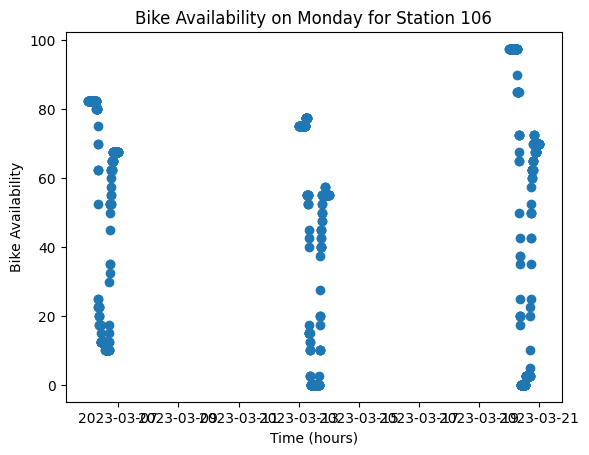

In [148]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays['datetime'], df_mondays['availability_percentage'])
plt.title("Bike Availability on Monday for Station 106")
plt.ylabel("Bike Availability")
plt.xlabel("Time (hours)")
plt.show()


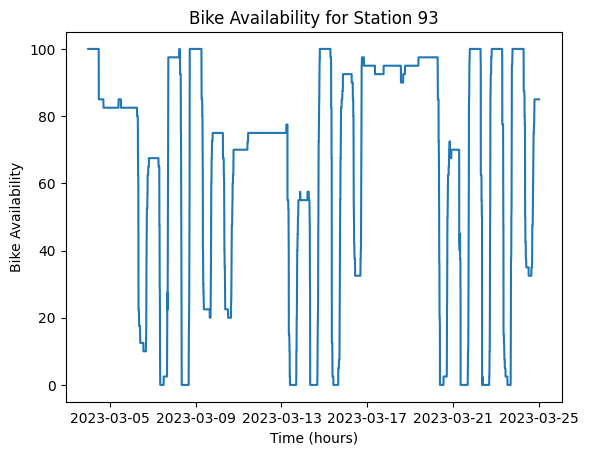

In [150]:
# filter the DataFrame to only include data for one station
df_station = df_main[df_main['number'] == 93]

# create scatter plot using the filtered DataFrame
plt.plot(df_station['datetime'], df_station['availability_percentage'])
plt.title("Bike Availability for Station 93")
plt.ylabel("Bike Availability")
plt.xlabel("Time (hours)")
plt.show()


IndexError: list index out of range

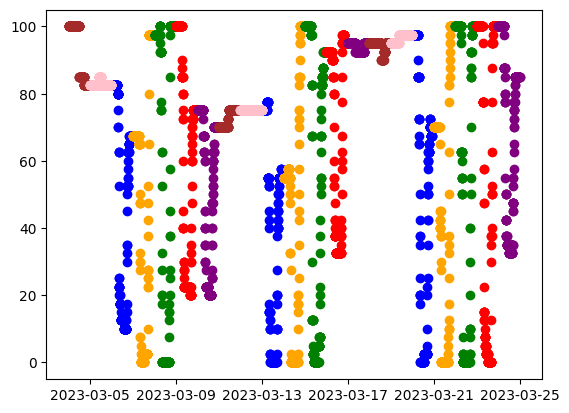

In [158]:
# filter the DataFrame to only include data for one station
df_station = df_main[df_main['number'] == 93]

# create a list of colors to use for each day of the week
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# create scatter plot for each day of the week using the filtered DataFrame
for i in range(0,24):
    # filter the DataFrame to only include data for the current day of the week
    df_day = df_station[df_station['datetime'].dt.dayofweek == i]

    # create scatter plot for the current day of the week
    plt.scatter(df_day['datetime'], df_day['availability_percentage'], color=colors[i], label=df_day['datetime'].dt.day_name().unique()[0])

# set plot title, x-axis label, and legend
plt.title("Bike Availability for Station 93 by Day of the Week")
plt.xlabel("Time (hours)")
plt.ylabel("Bike Availability")
plt.legend(title="Day of the Week")

# show the plot
plt.show()


### Conclusion- hours is too granular need more precision?